**Task: to check the correctness of the splitting system by conducting 10,000 comparisons of subsamples from the compared user groups №2 and №3**

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as plt
import hashlib
from tqdm.auto import tqdm

**Taking CTR for group 2 and 3 from database for the period: 2022-10-26 - 2022-11-01**

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221120',
                      'user':'', 
                      'password':
                     }

In [3]:
query = """


SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-10-26' and '2022-11-01'
    and exp_group in (2,3)
GROUP BY exp_group, user_id

"""


df = ph.read_clickhouse(query, connection=connection)
df.head()


,exp_group,user_id,likes,views,ctr
0,3,115383,4,9,0.444444
1,3,10326,19,65,0.292308
2,3,123580,3,23,0.130435
3,2,131473,2,13,0.153846
4,2,23985,0,11,0.000000


**To be sure, we check that the number of users in the groups is approximately the same and there is no statistically significant difference in the CTR distributions of the two groups**

In [4]:
df.groupby('exp_group', as_index = False).count()

,exp_group,user_id,likes,views,ctr
0,2,14467,14467,14467,14467
1,3,14620,14620,14620,14620


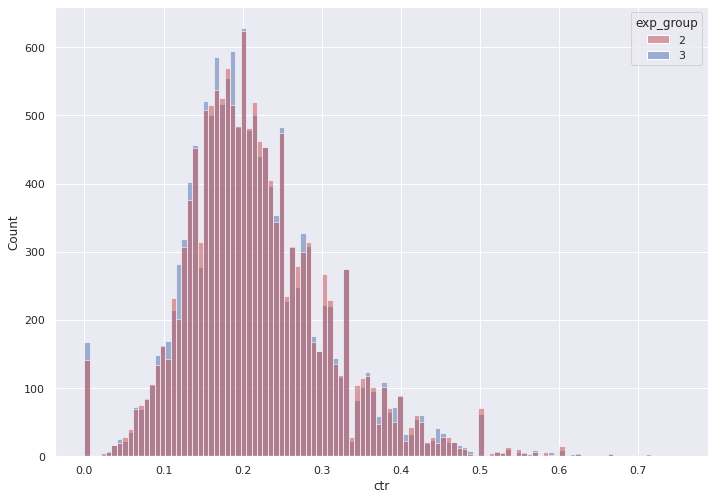

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [6]:
stats.ttest_ind(df[df.exp_group == 2].ctr, df[df.exp_group == 3].ctr, equal_var=False)

Ttest_indResult(statistic=1.230063886712762, pvalue=0.218683131143066)

**We extract subsamples without  duplication of data and perform the corresponding calculations**

In [7]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    boot_len = 500, # величина подвыборки
):
    boot_data = []
    stat_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = False # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,
            replace = False
        ).values
        
        stat, p_result = stats.ttest_ind(samples_1,
                samples_2,
                equal_var=False)
        
        boot_data.append(p_result)
        stat_data.append(stat)
    pd_boot_data = pd.DataFrame(boot_data)
    pd_stat_data = pd.DataFrame(stat_data)
        
    # Визуализация
    plt.hist(pd_boot_data[0])
    plt.style.use('ggplot')
    plt.xlabel('p-value')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    plt.hist(pd_stat_data[0])
    plt.xlabel('stat_data')
    plt.ylabel('frequency')
    plt.title("Histogram of stat_data")
    plt.show()
    
    return {"boot_data": boot_data}

  0%|          | 0/10000 [00:00<?, ?it/s]

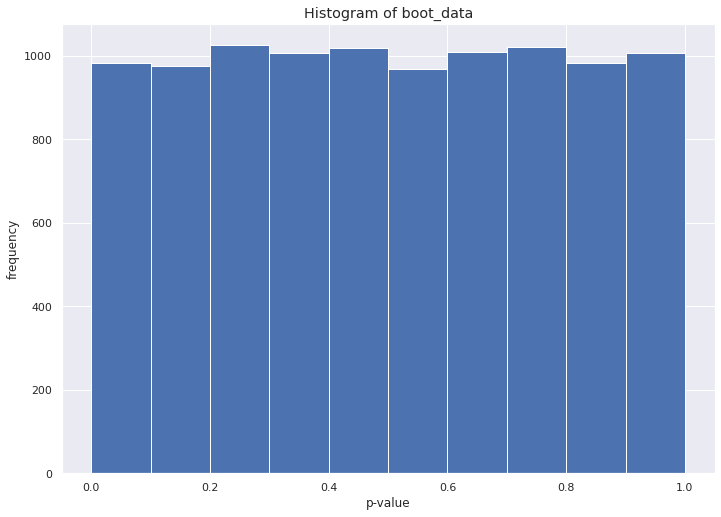

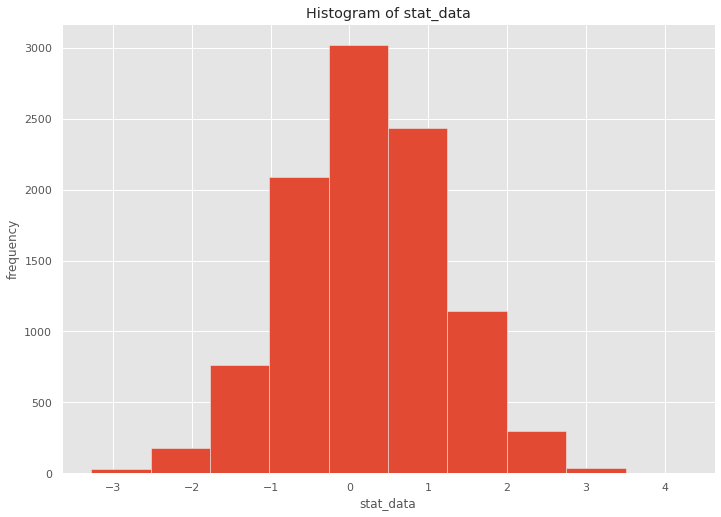

In [8]:
booted_data = get_bootstrap(df[df.exp_group == 2].ctr, df[df.exp_group == 3].ctr)

In [12]:
pd.DataFrame(booted_data["boot_data"]).quantile(0.05)

0    0.049913
Name: 0.05, dtype: float64

**Conclusion: as a result of 10,000 comparisons of subsamples of CTR values of groups 2 and 3, p-value was obtained. In this case, the 5% quantile of the resulting p-value distribution is 0.049, i.e. only in 5% of cases we got a statistically significant difference. Thus, the splitting system works correctly**